Notebook taken from [Predicting Credit Risk](https://www.kaggle.com/code/kabure/predicting-credit-risk-model-pipeline)


Should use https://www.kaggle.com/code/heidarmirhajisadati/credit-risk-prediction-using-german-credit-data

# Dataset

Trimmed [Credit risk dataset](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data) to have only:

<b>Age </b>(numeric)<br>
<b>Sex </b>(text: male, female)<br>
<b>Job </b>(numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)<br>
<b>Housing</b> (text: own, rent, or free)<br>
<b>Saving accounts</b> (text - little, moderate, quite rich, rich)<br>
<b>Checking account </b>(numeric, in DM - Deutsch Mark)<br>
<b>Credit amount</b> (numeric, in DM)<br>
<b>Duration</b> (numeric, in month)<br>
<b>Purpose</b>(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others<br>
<b>Risk </b> (Value target - Good or Bad Risk)<br>

# Setup

In [27]:
import json

import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn

import plotly.offline as py 
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.tools as tls # It's useful to we get some tools of plotly
import warnings # This library will be used to ignore some warnings
from collections import Counter # To do counter of some features
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, fbeta_score, recall_score
)

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.utils import resample
from sklearn.metrics import roc_curve

warnings.filterwarnings('ignore')
py.init_notebook_mode(connected=True) # this code, allow us to work with offline plotly version

In [2]:
%load_ext autoreload
%autoreload 2

from eda import (
    analyse_target_distribution,
    analyse_per_generation,
    analyse_per_property,
    analyse_per_gender,
    analyse_risk_per_saving,
)

# Data


In [3]:
df_credit = pd.read_csv("../input/german-credit-data-with-risk/german_credit_data.csv",index_col=0)
print(df_credit.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB
None


In [4]:
df_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


# EDA

## Target label distribution

There is an imbalance but not too much. Hence, no re-balance to apply.

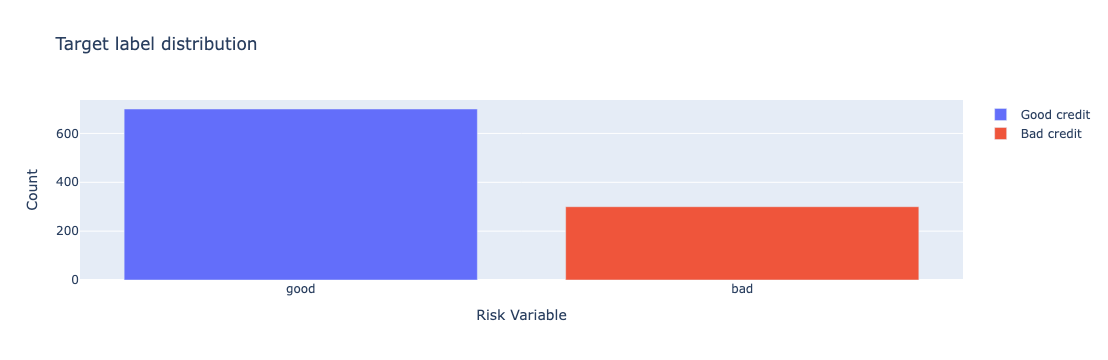

In [5]:
analyse_target_distribution(df=df_credit)

## Risk at Age Category 

Adult that have higher credit limit incurred higher debts, then senior. 

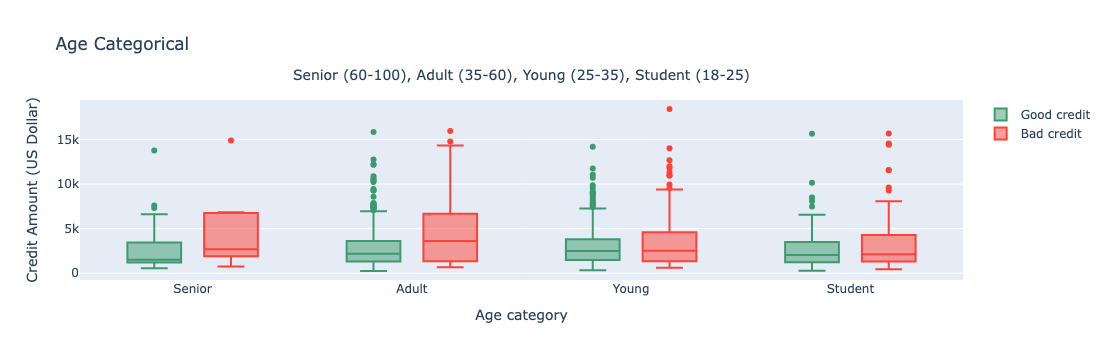

In [6]:
analyse_per_generation(df=df_credit)

## Risk at Property Category 

People with no morgage nor rent incurred high debts and risk.

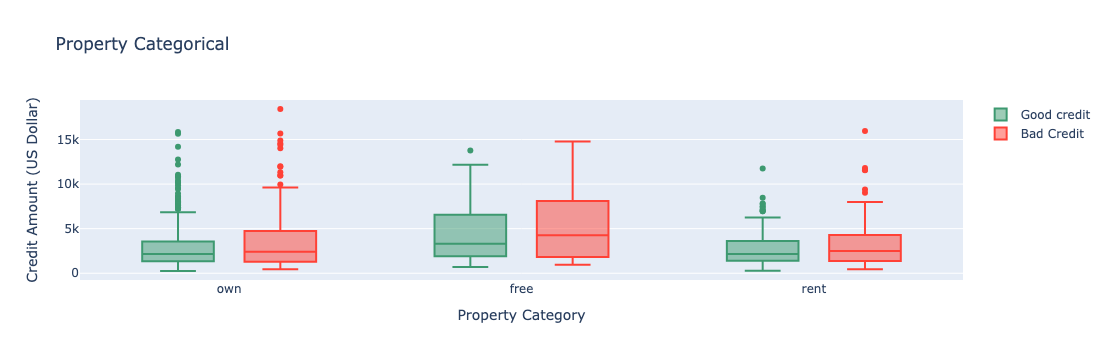

In [7]:
analyse_per_property(df=df_credit)

## Risk at Gender

Male incurred more and higher debts than female.

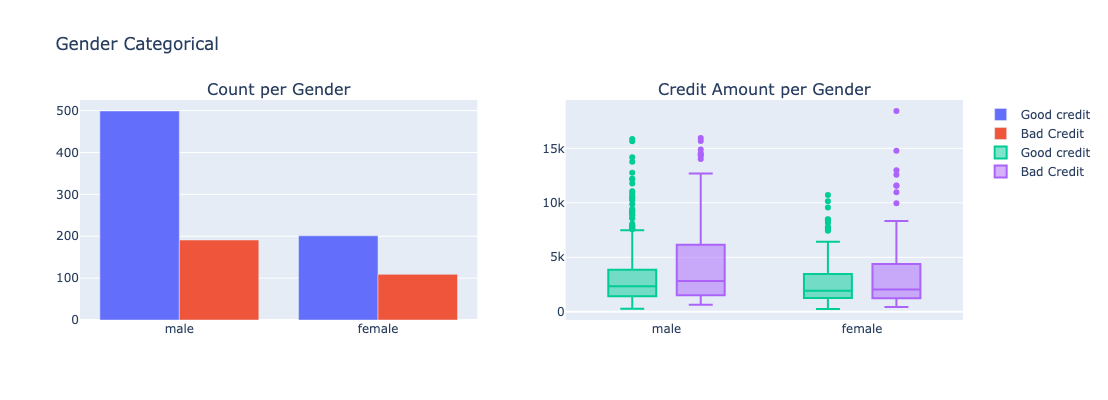

In [8]:
analyse_per_gender(df=df_credit)

## Risk per Saving


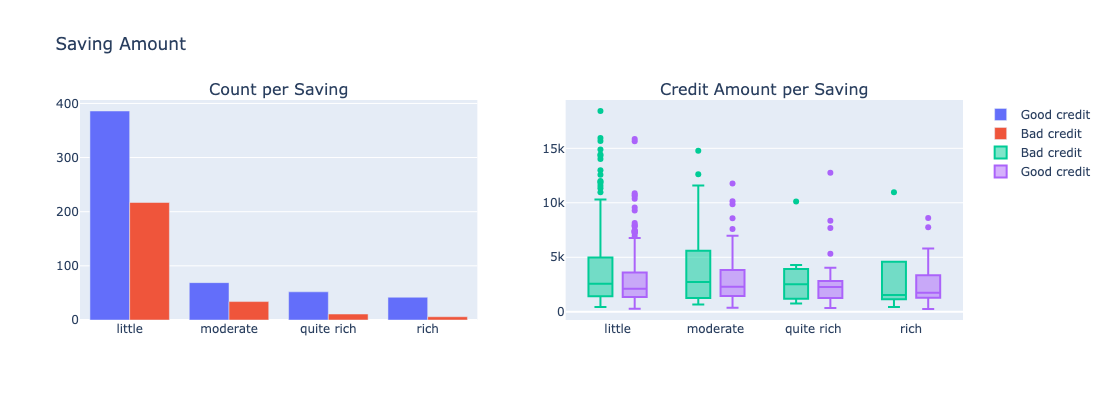

In [9]:
analyse_risk_per_saving(df=df_credit)

# Featur Engineering

### Imputation of missing values

In [10]:
df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

### Categorical to One Hot Encoding

In [11]:
df_credit = df_credit.merge(pd.get_dummies(df_credit.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
df_credit = df_credit.merge(pd.get_dummies(df_credit.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)
df_credit = df_credit.merge(pd.get_dummies(df_credit.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
df_credit = df_credit.merge(pd.get_dummies(df_credit["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
df_credit = df_credit.merge(pd.get_dummies(df_credit.Risk, prefix='Risk'), left_index=True, right_index=True)
df_credit = df_credit.merge(pd.get_dummies(df_credit["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
df_credit = df_credit.merge(pd.get_dummies(df_credit["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)
df_credit = df_credit.merge(pd.get_dummies(df_credit["Job"], drop_first=True, prefix='Job_cat'), left_index=True, right_index=True)

### Drop unused columns

In [12]:
del df_credit["Saving accounts"]
del df_credit["Checking account"]
del df_credit["Purpose"]
del df_credit["Sex"]
del df_credit["Housing"]
del df_credit["Age_cat"]
del df_credit["Risk"]
del df_credit['Risk_good']
del df_credit["Age"]
del df_credit["Job"]
del df_credit["Duration"]

### Cosmetic column renaming

In [13]:
df_credit.rename(columns={'Sex_male': 'Gender'}, inplace=True)
df_credit.rename(columns={'Credit amount': 'Credit_amount'}, inplace=True)
df_credit.rename(columns={'Risk_bad': 'Risky'}, inplace=True)

## Numeric Scaling

Loan or saving value distribution is long/right tail. Log transformation suits for such data.

In [14]:
df_credit['Credit_amount'] = np.log(df_credit['Credit_amount'])

# Features for Model Consumption

Verify the features to be consumed by the Model Training

In [15]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Credit_amount                1000 non-null   float64
 1   Purpose_car                  1000 non-null   bool   
 2   Purpose_domestic appliances  1000 non-null   bool   
 3   Purpose_education            1000 non-null   bool   
 4   Purpose_furniture/equipment  1000 non-null   bool   
 5   Purpose_radio/TV             1000 non-null   bool   
 6   Purpose_repairs              1000 non-null   bool   
 7   Purpose_vacation/others      1000 non-null   bool   
 8   Gender                       1000 non-null   bool   
 9   Housing_own                  1000 non-null   bool   
 10  Housing_rent                 1000 non-null   bool   
 11  Savings_moderate             1000 non-null   bool   
 12  Savings_no_inf               1000 non-null   bool   
 13  Savings_quite rich      

In [16]:
df_credit.head()

,Credit_amount,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Gender,Housing_own,...,Risky,Check_moderate,Check_no_inf,Check_rich,Age_cat_Young,Age_cat_Adult,Age_cat_Senior,Job_cat_1,Job_cat_2,Job_cat_3
0,7.063904,False,False,False,False,True,False,False,True,True,...,False,False,False,False,False,False,True,False,True,False
1,8.691315,False,False,False,False,True,False,False,False,True,...,True,True,False,False,False,False,False,False,True,False
2,7.647786,False,False,True,False,False,False,False,True,True,...,False,False,True,False,False,True,False,True,False,False
3,8.972337,False,False,False,True,False,False,False,True,False,...,False,False,False,False,False,True,False,False,True,False
4,8.490849,True,False,False,False,False,False,False,True,False,...,True,False,False,False,False,True,False,False,True,False


---


# Model Training 


In [17]:
#Creating the X and y variables
X = df_credit.drop(columns=['Risky']).values
y = df_credit["Risky"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

## Algorithsm Comparision

Gaussian Naive Bayes gives the best recall.

In [18]:
# to feed the random state
seed = 7

# prepare models
models = []
models.append(('XGB', XGBClassifier()))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

# evaluate each model in turn
results = []
scoring = 'recall'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append((name, cv_results))
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

results.sort(reverse=True, key=lambda x: x[1].mean())

XGB: 0.433072 (0.085564)
Gaussian Naive Bayes: 0.595247 (0.086938)
SVM: 0.000000 (0.000000)


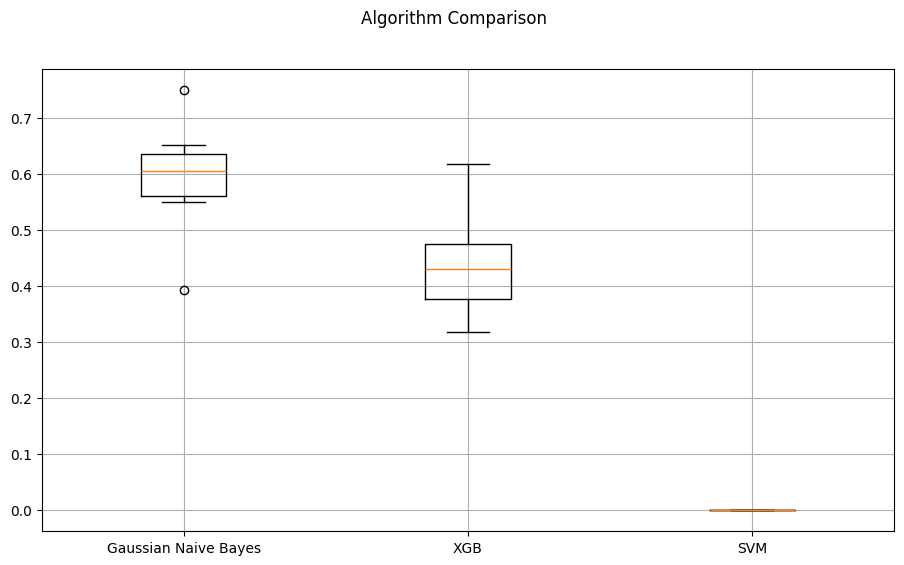

In [19]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot([x[1] for x in results])
ax.set_xticklabels([x[0] for x in results])
plt.grid()
plt.show()

# Train Models

Use GNB and XGB and compare the results

## GNB

* [Scikit-Learn GridSearchCV GaussianNB](https://sklearner.com/scikit-learn-grid-search-gaussiannb/)

In [20]:
features = []
features.append(('pca', PCA(n_components=2)))
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('logistic', GaussianNB()))
model = Pipeline(estimators)

# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.6799999999999999


In [21]:
# model.fit(X_train, y_train)

# Define parameter grid
param_grid = {
    'feature_union__pca__n_components': [1, 2, 3],       # Try different PCA components
    'feature_union__select_best__k': [4, 6, 8],          # Try different number of selected features
    'logistic__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6], # GaussianNB hyperparameter
}

# Create GridSearchCV
grid_gnb = GridSearchCV(model, param_grid, cv=kfold, scoring='recall', n_jobs=-1)

# Fit
grid_gnb.fit(X_train, y_train)

,estimator,Pipeline(step...aussianNB())])
,param_grid,"{'feature_union__pca__n_components': [1, 2, ...], 'feature_union__select_best__k': [4, 6, ...], 'logistic__var_smoothing': [1e-09, 1e-08, ...]}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformer_list,"[('pca', ...), ('select_best', ...)]"


In [22]:
print(f"GNB best score: {grid_gnb.best_score_}")
print(json.dumps(grid_gnb.best_params_, indent=4, default=str))

GNB best score: 0.5376593659963226
{
    "feature_union__pca__n_components": 3,
    "feature_union__select_best__k": 8,
    "logistic__var_smoothing": 1e-09
}


NOTE: SKLearn Confusion Matrix format:

```
[[TN FP]
 [FN TP]]
```

Recall:0.5138888888888888
Confusion Matrix
[[132  46]
 [ 35  37]]
F-Beta score: 0.49865229110512127
classification report
              precision    recall  f1-score   support

       False       0.79      0.74      0.77       178
        True       0.45      0.51      0.48        72

    accuracy                           0.68       250
   macro avg       0.62      0.63      0.62       250
weighted avg       0.69      0.68      0.68       250



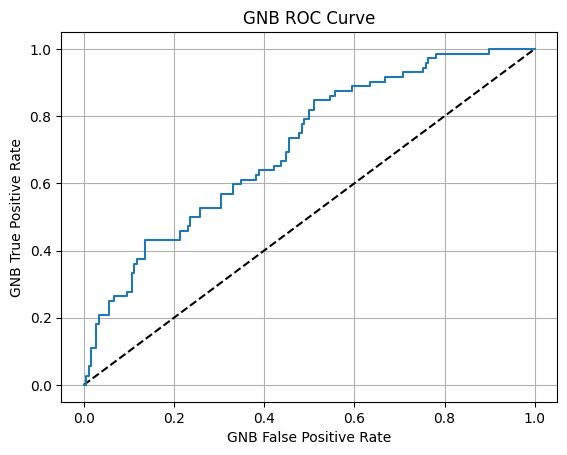

In [38]:
# y_pred_gnb = model.predict(X_test)
y_pred_gnb = grid_gnb.predict(X_test)

print(f"Recall:{recall_score(y_test,y_pred_gnb, pos_label=True)}")
print(f"Confusion Matrix\n{confusion_matrix(y_test, y_pred_gnb)}")
print(f"F-Beta score: {fbeta_score(y_test, y_pred_gnb, beta=2)}")
print(f"classification report\n{classification_report(y_test, y_pred_gnb)}")

#Predicting proba
#y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred_prob_gnb = grid_gnb.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr_gnb, tpr_gb, thresholds = roc_curve(y_test, y_pred_prob_gnb)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gnb, tpr_gb)
plt.xlabel('GNB False Positive Rate')
plt.ylabel('GNB True Positive Rate')
plt.grid()
plt.title('GNB ROC Curve')
plt.show()

## XGB

In [24]:
param_test1 = {
 'max_depth':[3,5,6,10],
 'min_child_weight':[3,5,10],
 'gamma':[0.0, 0.1, 0.2, 0.3, 0.4],
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

#Creating the classifier
model_xg = XGBClassifier(random_state=2)

grid_xb = GridSearchCV(model_xg, param_grid=param_test1, cv=5, scoring='recall')
grid_xb.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.75, 0.8, ...], 'gamma': [0.0, 0.1, ...], 'max_depth': [3, 5, ...], 'min_child_weight': [3, 5, ...], ...}"
,scoring,'recall'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [41]:
sum(y_test)

np.int64(72)

In [25]:
grid_xb.best_score_
grid_xb.best_params_

{'colsample_bytree': 0.85,
 'gamma': 0.2,
 'max_depth': 10,
 'min_child_weight': 3,
 'subsample': 0.75}

Recall:0.3888888888888889
Confusion Matrix
[[149  29]
 [ 44  28]]
F-Beta score: 0.4057971014492754
classification report
              precision    recall  f1-score   support

       False       0.77      0.84      0.80       178
        True       0.49      0.39      0.43        72

    accuracy                           0.71       250
   macro avg       0.63      0.61      0.62       250
weighted avg       0.69      0.71      0.70       250



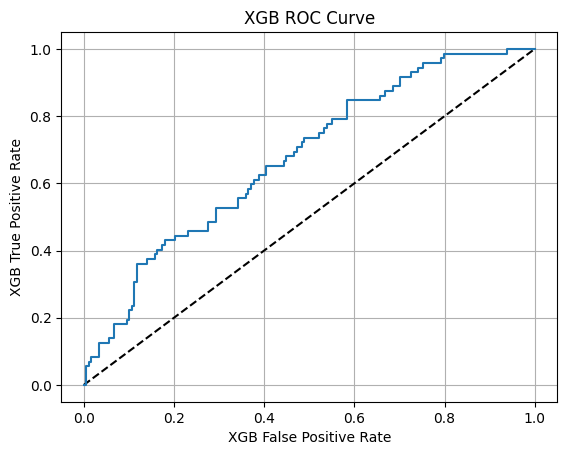

In [39]:
# y_pred = model.predict(X_test)
y_pred_xb = grid_xb.predict(X_test)

print(f"Recall:{recall_score(y_test,y_pred_xb, pos_label=True)}")
print(f"Confusion Matrix\n{confusion_matrix(y_test, y_pred_xb)}")
print(f"F-Beta score: {fbeta_score(y_test, y_pred_xb, beta=2)}")
print(f"classification report\n{classification_report(y_test, y_pred_xb)}")

#Predicting proba
#y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred_prob_xb = grid_xb.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr_xb, tpr_xb, thresholds = roc_curve(y_test, y_pred_prob_xb)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_xb, tpr_xb)
plt.xlabel('XGB False Positive Rate')
plt.ylabel('XGB True Positive Rate')
plt.grid()
plt.title('XGB ROC Curve')
plt.show()

# Conclusion

Both 